In [1]:
import numpy as np
import csv
import random
import math
import matplotlib

import matplotlib.pyplot as plt

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import copy
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.datasets as datasets
import torch.optim as optim
from torch import utils
from torch.utils import data
from torch.utils.data import Dataset, DataLoader
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(3)
CUDA_LAUNCH_BLOCKING=1

print (use_cuda)

torch.backends.cudnn.enabled
import os


import time
import pandas
import seaborn
import sklearn as sk

True


In [2]:
from ase import Atoms
from ase.calculators.emt import EMT
from ase.db import connect


from clease.tools import update_db
from clease import Concentration
from clease import CEBulk
from clease import Evaluate
from clease import NewStructures
from clease.calculator import Clease
from clease.calculator import attach_calculator

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
import numpy as np

import json
with open('ECI_CuAu_Final_Submission.json') as json_file: 
    eci = json.load(json_file) 
    
conc = Concentration(basis_elements=[['Au', 'Cu']])
settings = CEBulk(crystalstructure='fcc',
                   a=3.8,
                   size=[2,2,4],
                   concentration=conc,
                   db_name="aucu_dft.db",
                   max_cluster_size=4,
                   max_cluster_dia=[6.0, 4.5, 4.5])

atoms = settings.atoms.copy()
atoms = attach_calculator(settings, atoms=atoms, eci=eci)

gmeans = np.linspace(0,1,51)
gmeans_ten = torch.tensor(gmeans).cuda()

k_b = 0.00008617

def get_concentrations(lattices):
    lattices = ((lattices+1)/2).view(lattices.shape[0],-1)
    Au_conc = torch.sum(lattices,dim=1)/(16)
    return Au_conc

In [3]:
print(eci)

{'c0': 0.006100279787831659, 'c1_0': -0.0031900811734577247, 'c2_d0000_0_00': 0.017232296461428938, 'c2_d0001_0_00': -0.016839573363374966, 'c2_d0002_0_00': -0.005192441582986464, 'c2_d0003_0_00': -0.00042240992321274096, 'c3_d0000_0_000': -0.00770642159861723, 'c3_d0001_0_000': 0.008232628244981447, 'c4_d0000_0_0000': -0.0003380467088204115, 'c4_d0001_0_0000': -0.015681090820390833, 'c4_d0002_0_0000': 0.015097011177476766}


In [4]:

###### Based off Wu et Al. Solving Statistical Mechanics Using Variational Autoregressive Networks


def KL_loss(DBG,lattices,epoch,temp,field,num_temps,num_fields):
    lattices = lattices.detach()
    probs = DBG.get_sample_prob(lattices,temp,field,epoch).view(lattices.shape[0])
    with torch.no_grad():
        energies = DBG.get_energies(lattices).view(lattices.shape[0])
        energies_norm = energies.view(-1)

        F = (energies_norm).view(-1,1) + probs.view(-1,1)*(temp.view(-1,1)*k_b)
        F_new = F - (field.view(-1,1) * lattices.view(-1,DBG.Nz).sum(dim=1).view(-1,1))
        #if epoch % 20 == 0:
        #    print('data')
        #    print(energies_norm.mean())
        batch = int(lattices.shape[0]/(num_temps*num_fields))
        F_mean_r = F_new.view(-1,num_fields).view(num_temps,-1,num_fields)
        F_mean = F_mean_r.mean(dim=1).view(num_temps,1,num_fields).expand(num_temps,batch,num_fields)
        F_std = F_mean_r.std(dim=1).view(num_temps,1,num_fields).expand(num_temps,batch,num_fields)
        R = (F_new.view(-1) - F_mean.reshape(-1))/torch.abs(F_mean.reshape(-1))
        
        log_unbiased = -F_new
        shift = log_unbiased.mean()
        log_unbiased = log_unbiased-shift
        unbiased = torch.exp(log_unbiased)
    assert not R.requires_grad
    assert probs.requires_grad
    return torch.mean(R*probs),unbiased.mean(),shift,F_mean_r.mean(dim=1)

In [5]:
temps_sim = [0]
field_sim = [-0.12,0.12]
field_temp = [0,0,0,0]
coordinate_cutoff = 4.0
def train_model(DBG,optimizer,batch_size,is_anneal,anneal_rate,factor):
    
    epoch = 0
    temp = torch.zeros(batch_size).cuda()
    field = torch.zeros(batch_size).cuda()
    print_log_header()
    kl_losses = np.zeros((5000))
    free_energy_estimates = np.zeros((5000))
    epochs = np.zeros((5000))
    while epoch < 5000:
        for i in range(len(field_temp)):
            field_temp[i] = field_sim[0] + (field_sim[1]-field_sim[0])*np.random.rand()
        for i in range(batch_size):
            temp[i] = temps_sim[int(i/batch_size)] + factor*anneal_rate**epoch
        for i in range(batch_size):
            field[i] = (field_temp[int(i%(len(field_temp)))])
        epoch = epoch + 1
        lattices = DBG.forward(temp,field)
        kl_loss,unbiased,shift,F = KL_loss(DBG,lattices,epoch,temp,field,1,len(field_temp))
        
       
        optimizer.zero_grad()
        kl_loss.backward()
        
        optimizer.step()
            
        epochs[epoch-1] = epoch
        kl_losses[epoch-1] = kl_loss.cpu().detach().numpy()
       
    return DBG,epochs,kl_losses

In [6]:
def print_log_header():
    print ('{:>8} {:>12}'\
       .format('epoch','train loss'))
    
def print_training_log(epoch, train_loss, test_loss=None):
    if test_loss is not None:
        print ('{:>8} {:>8} {:>12.4f} {:>12.4f}'\
                   .format(epoch, train_loss, test_loss))
        f.write('{:>8} {:>8} {:>12.4f} {:>12.4f}\n'\
                   .format(epoch, train_loss, test_loss))
    else:
        print ('{:>8} {:>8}'\
                   .format(epoch, train_loss))

In [7]:
def one_hot_to_sites(lattices,Nz):
    lattices = lattices.view(-1,Nz,2)
    lattices = torch.argmax(lattices,dim=2)
    lattices = 2*lattices - 1.0
    lattices = lattices.view(-1,Nz)
    return lattices.float()
    
def sites_to_one_hot(lattices):
    lattices = lattices.view(lattices.shape[0],-1)
    lattices = (0.5*(lattices + 1)).long()
    one_hot_lattices = torch.zeros(lattices.shape[0],lattices.shape[1],2).float().cuda()
    one_hot_lattices = one_hot_lattices.scatter_(2,lattices.view(lattices.shape[0],-1,1),1.0)
    return one_hot_lattices.detach()

In [8]:

    
def mask_weight(m,disp):
    num_sites = m.shape[1]
    num_components = 2
    mask = torch.zeros(m.shape)
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            if (disp == 0):
                if (j == 0 or j == 1 ):
                    mask[i,j] = 1.0
                elif ((j-2) < num_components*int(i/num_components) ):
                    mask[i,j] = 1.0
            if (disp == 1):
                if (j == 0 or j==1 ):
                    mask[i,j] = 1.0
                if ((j-2) < num_components*int(i/num_components) + num_components):
                    mask[i,j] = 1.0
    mask = mask.detach()
    m_masked = m*mask
    return m_masked

# Zero out gradients
def get_zero_grad_hook(mask):
    def hook(grad):
        return grad * mask
    return hook

In [9]:
class autoreg_model(nn.Module):
    def __init__(self,Nz,assignments):
        super().__init__()
        self.Nz = Nz
        self.Dim = int(math.sqrt(Nz))
        self.assignments = assignments
        self.activation = nn.Sigmoid()
        self.lsoftmax = torch.nn.LogSoftmax(dim=2)
        self.softmax = torch.nn.Softmax(dim=2)
        self.shared_layer = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer.weight,0))
        self.mask_1 = mask_weight(torch.ones_like(self.shared_layer.weight),0).cuda()
        
        self.shared_layer.weight.register_hook(get_zero_grad_hook(self.mask_1))
        
        self.shared_layer_2 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_2.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_2.weight,1))
        self.mask_2 = mask_weight(torch.ones_like(self.shared_layer_2.weight),1).cuda()

        self.shared_layer_2.weight.register_hook(get_zero_grad_hook(self.mask_2))
        
        self.shared_layer_3 = nn.Linear(2*self.Nz+2,2*self.Nz,bias=False)
        with torch.no_grad():
            self.shared_layer_3.weight.copy_(np.sqrt(2)*mask_weight(self.shared_layer_3.weight,1))
        self.mask_3 = mask_weight(torch.ones_like(self.shared_layer_3.weight),1).cuda()
        
        self.shared_layer_3.weight.register_hook(get_zero_grad_hook(self.mask_3))
        
    def get_sample_prob(self,lattices,temp,field,epoch):
        
        batch_size = temp.shape[0]
        samples = sites_to_one_hot(lattices).view(batch_size,-1)
        net_in = torch.cat((field.view(-1,1)*10,samples),dim=1)
        net_in = torch.cat((temp.view(-1,1)/1000,net_in),dim=1)
        conditional = self.activation(self.shared_layer(net_in))
        conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
        conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
        conditional = self.shared_layer_2(conditional)
        conditional = self.activation(conditional)
        conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
        conditional = torch.cat((temp.view(-1,1)/1000,conditional),dim=1)
        conditional = self.shared_layer_3(conditional)
        conditional = conditional.view(-1,self.Nz,2)
        Probs = self.lsoftmax(conditional)
        samples = samples.detach()
        #assert sample.requires_grad == False
        assert Probs.requires_grad == True
        site_prob = Probs*(samples.view(-1,self.Nz,2))
        probs = torch.sum(torch.sum(site_prob,dim=2),dim=1)
        return probs
        
    def forward(self,temp,field):
        
        batch_size = temp.shape[0]
        temp = temp.view(-1,1)/1000
        field = field.view(-1,1)
        lattices = torch.zeros(batch_size,2*self.Nz).cuda()
        for site in range(self.Nz):
            net_in = torch.cat((field*10,lattices),dim=1)
            net_in = torch.cat((temp,net_in),dim=1)
            conditional = self.activation(self.shared_layer(net_in))
            conditional = torch.cat((field*10,conditional),dim=1)
            conditional = torch.cat((temp,conditional),dim=1)
            conditional = self.shared_layer_2(conditional)
            conditional = self.activation(conditional)
            conditional = torch.cat((field.view(-1,1)*10,conditional),dim=1)
            conditional = torch.cat((temp.view(-1,1),conditional),dim=1)
            conditional = self.shared_layer_3(conditional)
            conditional = conditional.view(-1,self.Nz,2)
            
            Probs = self.softmax(conditional)
            To_Sample = Probs[:,site,:]
            
            sample = torch.multinomial(To_Sample,1).view(-1,1)
            lattices = lattices.view(-1,self.Nz,2)
            lattices[:,site,:] = lattices[:,site,:].scatter_(1,sample,1)
            lattices = lattices.view(-1,2*self.Nz)
        lattices = one_hot_to_sites(lattices,self.Nz)
        return lattices

def create_model(Nz,assignments):
    class Discrete_Boltzmann_Generator(nn.Module):
        def __init__(self,Nz,assignments):
            super().__init__()
            self.Nz = Nz
            self.Dim = int(math.sqrt(Nz))
            self.assignment = assignments
            self.Model = autoreg_model(Nz,assignments)
            atoms.numbers = np.ones((self.Nz))*29
            self.U_cu = atoms.get_potential_energy()
            atoms.numbers = np.ones((self.Nz))*79
            self.U_au = atoms.get_potential_energy()
            
        def forward(self,temp,field):
            return self.Model.forward(temp,field)
            
        def get_energies(self,lattices):
            lattices = lattices.view(lattices.shape[0],-1)
            energies = torch.zeros(lattices.shape[0]).cuda()
            for lattice_num in range(lattices.shape[0]):
                energies[lattice_num] = self.get_cluster_energy(lattices[lattice_num,:])
            return energies
        
        def get_cluster_energy(self,lattice):
            ## Cu = 29
            ## Au = 79
            atoms.numbers = ((lattice*25)+54).int().cpu().detach().numpy()
            energy_t = atoms.get_potential_energy()
            lattice = ((lattice+1)/2).view(-1)
            Au_conc = torch.sum(lattice,dim=0)/(self.Nz)
            energy_t = energy_t - (1-Au_conc)*(self.U_cu) - (Au_conc)*(self.U_au)
            return energy_t
        
        def get_sample_prob(self,sample,temp,field,epoch):
            return self.Model.get_sample_prob(sample,temp,field,epoch)
        
    model = Discrete_Boltzmann_Generator(Nz,assignments).cuda()
    batch_size = assignments['batch_size']
    optimizer = optimizers[assignments['optimizer']](model.parameters(), lr=10**assignments['log_learning_rate'])
    kl_loss = assignments['kl_loss']
    is_anneal = assignments['is_anneal']
    anneal_rate = assignments['anneal_rate']
    factor = assignments['factor']
    model,epochs,kl_losses = train_model(model,optimizer,batch_size,is_anneal,anneal_rate,factor)
    
    return model,epochs,kl_losses

In [10]:
activation_functions = {
    'relu': nn.ReLU(),
    'sigmoid': nn.Sigmoid(),
    'tanh': nn.Tanh(),
}

optimizers = {
    'gradient_descent': optim.SGD,
    'rmsprop': optim.RMSprop,
    'adam': optim.Adam,
}

assignments = {
    "batch_size": 200,
    "log_learning_rate": -3,
    "optimizer": "adam",
    "rc_loss": 0,
    "rc_alter": 0,
    "kl_loss": 1,
    "is_anneal": 0,
    "anneal_rate": 0.999,
    "factor": 3000.0,
    'num_rc': 100
}


In [11]:
model,epochs,kl_losses = create_model(2*2*4,assignments)


   epoch   train loss


In [17]:
torch.save(model.state_dict(), "CuAuGS_model")

In [12]:
hull = {}
hull[0.0] = 0.0

hull[0.25] = -0.0341671942368
hull[0.50] = -0.0361824880
hull[0.75] = -0.018754351039661
hull[1.0] = 0.0

In [18]:
print(hull[0.25]*2.0)
print((hull[0.50]-hull[0.25])*2.0)
print((hull[0.75]-hull[0.5])*2.0)
print((hull[1.0]-hull[0.75])*2.0)


-0.0683343884736
-0.004030587526399995
0.034856273920678
0.037508702079322


In [23]:
def get_min_fe(ch_pot):
    if ch_pot < hull[0.25]*2.0:
        return 0.0
        
    elif ch_pot < (hull[0.50]-hull[0.25])*2.0:
        return -0.0341671942368*16  - 2*ch_pot*4.0 
        
    elif ch_pot < (hull[0.75]-hull[0.5])*2.0:
        return -0.0361824880*16 - 2*ch_pot*8.0 
        
    elif ch_pot < (hull[1.0]-hull[0.75])*2.0:
        return -0.01875435*16 - 2*ch_pot*12.0 
        
    else:
        return - 2*ch_pot*16.0 
        

In [24]:
def get_concentrations(lattices):
    lattices = ((lattices+1)/2).view(lattices.shape[0],-1)
    Au_conc = torch.sum(lattices,dim=1)/(2*2*4)
    return Au_conc

In [25]:
def samples_for_rw(model,samples_per_batch,temp,field_range):
    z_samp = torch.rand((samples_per_batch,Dim*Dim)).cuda()
    temp_b = torch.zeros(samples_per_batch).cuda()
    field_b = torch.zeros(samples_per_batch).cuda()
    for i in range(samples_per_batch):
        temp_b[i] = temp
        field_b[i] = field_range[0] + i*(field_range[1]-field_range[0])/samples_per_batch
    lattices = model.forward(temp_b,field_b)
    Au_conc = get_concentrations(lattices).cpu().detach().numpy()
    energies = model.get_energies(lattices)
    probs = model.get_sample_prob(lattices,temp_b,field_b,1000)
    R_s = energies/(temp*0.00008617) + probs
    weights = (-R_s).cpu().detach().numpy()
    probs = probs.cpu().detach().numpy()
    energies = energies.cpu().detach().numpy()
    return Au_conc,weights,probs,energies,field_b.cpu().detach().numpy()

In [26]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#003f5c
#58508d
#bc5090
#ff6361
#ffa600
N = 5
newcolors = []
newcolors.append((0,63,92))
newcolors.append((88,80,141)) 
newcolors.append((188,80,144)) 
newcolors.append((255,99,97)) 
newcolors.append((255,166,0)) 

newcolors_norm = []
for i in newcolors:
    curr = np.asarray(i)
    print(curr)
    curr = curr/255.0
    curr = tuple(curr)
    newcolors_norm.append(curr)

cmap_name = 'my_list'
newcmp = LinearSegmentedColormap.from_list(cmap_name,newcolors_norm)

[ 0 63 92]
[ 88  80 141]
[188  80 144]
[255  99  97]
[255 166   0]


[ 0.          0.          0.          0.          0.          0.
  0.         -0.03416719 -0.03416719 -0.03416719 -0.03416719 -0.03416719
 -0.03416719 -0.03416719 -0.03416719 -0.03416719 -0.03416719 -0.03416719
 -0.03416719 -0.03416719 -0.03618249 -0.03618249 -0.03618249 -0.03618249
 -0.03618249 -0.03618249 -0.03618249 -0.01875435  0.          0.
  0.          0.          0.          0.          0.        ]


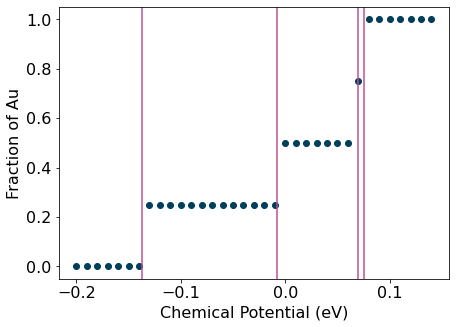

In [123]:

def get_comp_vs_potential(model,samples_per_batch,temp,field_range):
    num_batches = int((field_range[1]-field_range[0])*200)
    concs = np.zeros((num_batches))
    fields = np.zeros((num_batches))
    energies_st = np.zeros((num_batches))
    lattices_st = np.zeros((num_batches,model.Nz))
    min_fe = {}
    lat_2_5 = []
    lat_5_0 = []
    lat_7_5 = []
    for batch in range(num_batches):
        field_iter = field_range[0] + (batch/num_batches) * (field_range[1] - field_range[0])
        temp_b = torch.zeros(samples_per_batch).cuda()
        field_b = torch.zeros(samples_per_batch).cuda()
        for i in range(samples_per_batch):
            temp_b[i] = 0
            field_b[i] = field_range[0] + (batch/num_batches) * (field_range[1] - field_range[0])
        lattices = model.forward(temp_b,field_b)
        Au_conc = get_concentrations(lattices).cpu().detach().numpy()
        energies = model.get_energies(lattices)
        min_val = 999999999
        min_index = -1
        for i in range(samples_per_batch):
            temp_val = energies[i] - (2*field_b[i]*Au_conc[i])*model.Nz
            if (temp_val < min_val):
                min_index = i
                min_val = temp_val
        curr_lattice = lattices.view(-1,model.Nz).cpu().detach().numpy()[min_index,:]
        lattices_st[batch,:] = curr_lattice
        for i in range(samples_per_batch):
            temp_val = energies[i] - (2*field_b[i]*Au_conc[i])*model.Nz
            if (temp_val == min_val):
                curr_lattice = lattices.view(-1,model.Nz).cpu().detach().numpy()[i,:]
                if (Au_conc[i] == 0.25):
                    found = 0
                    for j in range(len(lat_2_5)):
                        if (np.array_equal(lat_2_5[j],curr_lattice)):
                            found = 1
                    if found == 0:
                        lat_2_5.append(curr_lattice)

                elif (Au_conc[i] == 0.50):
                    found = 0
                    for j in range(len(lat_5_0)):
                        if (np.array_equal(lat_5_0[j],curr_lattice)):
                            found = 1
                    if found == 0:
                        lat_5_0.append(curr_lattice)

                elif (Au_conc[i] == 0.75):
                    found = 0
                    for j in range(len(lat_7_5)):
                        if (np.array_equal(lat_7_5[j],curr_lattice)):
                            found = 1
                    if found == 0:
                        lat_7_5.append(curr_lattice)
            
        energies_st[batch] = energies[min_index]/model.Nz
        concs[batch] = Au_conc[min_index]
        fields[batch] = field_b.mean().cpu().detach().numpy()
        min_fe[round(field_iter,4)] = min_val.cpu().detach().numpy()
        
    print(energies_st)
    import matplotlib as mpl
    plt.rcParams["figure.figsize"] = (7,5)
    col = newcmp(0.0)
    plt.scatter(fields*2.0,concs,color=col)
    col = newcmp(0.5)  
    plt.axvline(x=-0.0683343884736*2.0,color=col)
    plt.axvline(x=-0.0040305875*2.0,color=col)
    plt.axvline(x=0.034856273920678*2.0,color=col)
    plt.axvline(x=0.03750870207*2.0,color = col)
    
    mpl.rc('font',family='Arial')
    hfont = {'fontname':'Arial'}
    plt.xlabel('Chemical Potential (eV)',fontsize=16,fontname="Arial")
    plt.xticks([-0.2,-0.1,0.0,0.1])
    plt.ylabel('Fraction of Au',fontsize=16,fontname="Arial")
    plt.xticks(fontsize = 16,fontname = "Arial") 
    plt.yticks(fontsize = 16,fontname = "Arial") 
    plt.savefig('chem_pot_vs_comp_aucu.pdf',bbox_inches='tight',transparent=True)
    plt.show()
    
    return lattices_st,lat_2_5,lat_5_0,lat_7_5,min_fe
    
lattices_st,lat_2_5,lat_5_0,lat_7_5,min_fe = get_comp_vs_potential(model,1000,1000,[-0.1,0.075])

In [125]:
def get_hull_fe_energies(lattices,cpot,min_fe):
    size = lattices.shape[0]
    out = np.zeros((size))
    act_min = get_min_fe(cpot)
    Au_conc = get_concentrations(lattices)
    energies = model.get_energies(lattices)
    vals = energies - (2*cpot*Au_conc)*16
    for i in range(size):
        curr_val = vals[i].cpu().detach().numpy()
        out[i] = (curr_val - act_min)
        
    return out

In [126]:
def get_energies_over_comp(chem_p,min_fe,size):
    
    random = np.zeros((chem_p.shape[0],size))
    model_vals = np.zeros((chem_p.shape[0],size))
    counter = 0
    for cpot in chem_p:
        temp_b = torch.zeros(size).cuda()
        field_b = torch.zeros(size).cuda()
        for i in range(size):
            temp_b[i] = 0
            field_b[i] = cpot
        model_lattices = model.forward(temp_b,field_b)
        random_lattices = torch.randint(0,2,(size,16)).cuda()
        random_lattices = (random_lattices*2.0) - 1.0
        random[counter,:] = get_hull_fe_energies(random_lattices,cpot,min_fe)
        model_vals[counter,:] = get_hull_fe_energies(model_lattices,cpot,min_fe)
        counter = counter + 1
    return random,model_vals

[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.903 0.891 0.833 0.774 0.685 0.617 0.502 0.561 0.674 0.755 0.827 0.89
 0.927 0.93  0.939 0.93  0.926 0.912 0.856 0.767 0.168 0.331 0.5   0.684
 0.708 0.639 0.473 0.017 0.615 0.759 0.808 0.886 0.924 0.942 0.952 0.963]
735.2222222222222


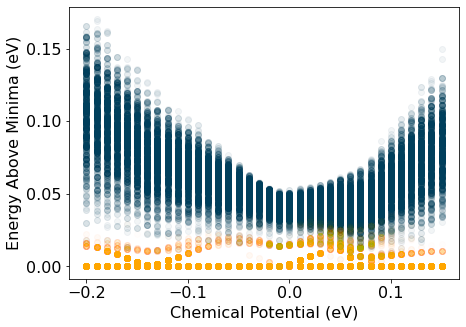

In [128]:
chem_p = np.linspace(-0.1,0.075,36)
holder = np.ones((1000))
random,model_vals = get_energies_over_comp(chem_p,min_fe,1000)



[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.001 0.    0.    0.    0.    0.    0.    0.    0.   ]
[0.903 0.891 0.833 0.774 0.685 0.617 0.502 0.561 0.674 0.755 0.827 0.89
 0.927 0.93  0.939 0.93  0.926 0.912 0.856 0.767 0.168 0.331 0.5   0.684
 0.708 0.639 0.473 0.017 0.615 0.759 0.808 0.886 0.924 0.942 0.952 0.963]
735.2222222222222


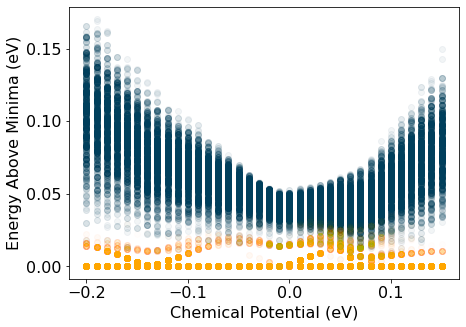

In [168]:
rand_count = np.zeros(36)
SEGAL_count = np.zeros(36)
counter = 0
for cpot in chem_p:
    place = holder*cpot
    
    for j in range(random.shape[1]):
        if random[counter,j] < 5e-7:
            rand_count[counter] += 1
        if model_vals[counter,j] < 5e-7:
            SEGAL_count[counter] += 1
    col = newcmp(0.0)  
    plt.scatter(2.0*place,random[counter,:]/16,alpha = 0.05,color=col)
    col = newcmp(1.0)
    plt.scatter(2.0*place,model_vals[counter,:]/16,alpha = 0.01,color=col)
    #print(min(abs(model_vals[counter,:])))
    counter = counter + 1
    
    
print(rand_count/1000)
print(SEGAL_count/1000)
print(np.mean(SEGAL_count))


import matplotlib as mpl
plt.rcParams["figure.figsize"] = (7,5)

mpl.rc('font',family='Arial')
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
plt.xlabel('Chemical Potential (eV)',fontsize=16,fontname="Arial")
plt.xticks([-0.2,-0.1,0.0,0.1])
plt.yticks([0.0,0.050,0.10,0.15])
plt.ylabel('Energy Above Minima (eV)',fontsize=16,fontname="Arial")
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
plt.savefig('all_sample.png',bbox_inches='tight',transparent=True, dpi=300)
plt.show()

In [134]:
def sensitivity_test(num):
    chem_p = []
    num_batches = int(num)
    samples_per_batch = 2500
    field_range = [-.1,.075]
    concs = np.zeros((num_batches))
    fields = np.zeros((num_batches))
    energies_st = np.zeros((num_batches))
    lattices_st = np.zeros((num_batches,model.Nz))
    min_fe = {}
    lat_2_5 = []
    lat_5_0 = []
    lat_7_5 = []
    
    if num == 18:
        chem_p = np.linspace(-0.1,0.07,18)
        
    else:
    
        for batch in range(num_batches):
            field_iter = field_range[0] + (batch/num_batches) * (field_range[1] - field_range[0])
            chem_p.append(field_iter)
        
    #print(min_fe.keys())
    print(chem_p)
    chem_p = np.asarray(chem_p)
    holder = np.ones((2500))
    random,model_vals = get_energies_over_comp(chem_p,min_fe,2500)
    rand_count = np.zeros(num)
    SEGAL_count = np.zeros(num)
    counter = 0
    for cpot in chem_p:
        place = holder*cpot

        for j in range(random.shape[1]):
            if random[counter,j] < 5e-7:
                rand_count[counter] += 1
            if model_vals[counter,j] < 5e-7:
                SEGAL_count[counter] += 1
        counter = counter + 1
        
    return chem_p,rand_count,SEGAL_count
    

In [135]:
ch_1,prob_1_r,prob_1_s = sensitivity_test(18)
ch_2,prob_2_r,prob_2_s = sensitivity_test(35)
ch_3,prob_3_r,prob_3_s = sensitivity_test(70)


[-0.1  -0.09 -0.08 -0.07 -0.06 -0.05 -0.04 -0.03 -0.02 -0.01  0.    0.01
  0.02  0.03  0.04  0.05  0.06  0.07]
[-0.1, -0.095, -0.09000000000000001, -0.085, -0.08000000000000002, -0.07500000000000001, -0.07, -0.065, -0.06000000000000001, -0.055000000000000014, -0.05000000000000001, -0.04500000000000001, -0.04000000000000001, -0.035, -0.030000000000000013, -0.02500000000000001, -0.020000000000000018, -0.015000000000000013, -0.010000000000000023, -0.005000000000000018, -1.3877787807814457e-17, 0.0049999999999999906, 0.009999999999999981, 0.014999999999999986, 0.01999999999999999, 0.024999999999999994, 0.03, 0.035, 0.03999999999999998, 0.044999999999999984, 0.04999999999999999, 0.054999999999999966, 0.05999999999999997, 0.06499999999999997, 0.06999999999999998]
[-0.1, -0.0975, -0.095, -0.0925, -0.09000000000000001, -0.08750000000000001, -0.085, -0.0825, -0.08000000000000002, -0.07750000000000001, -0.07500000000000001, -0.07250000000000001, -0.07, -0.0675, -0.065, -0.0625, -0.06000000000000

In [153]:
print(min(prob_1_s/2500.0))
print(min(prob_2_s/2500.0))
print(min(prob_3_s/2500.0))

print(prob_3_s/2500.0)

#57

print(min(prob_1_s))
print(min(prob_2_s))
print(min(prob_3_s))

0.1712
0.0108
0.0128
[0.908  0.8736 0.8748 0.8592 0.8296 0.816  0.7784 0.7372 0.6788 0.65
 0.588  0.5376 0.48   0.5084 0.5756 0.614  0.6568 0.7236 0.7684 0.812
 0.8476 0.8556 0.8912 0.9104 0.9328 0.93   0.9336 0.9468 0.9484 0.938
 0.9376 0.9404 0.9308 0.9152 0.8984 0.8724 0.83   0.8176 0.7756 0.1252
 0.182  0.2592 0.3464 0.4284 0.5416 0.5984 0.664  0.702  0.712  0.6852
 0.6284 0.5528 0.4828 0.3564 0.0128 0.0128 0.6092 0.6844 0.744  0.8096
 0.8172 0.8568 0.8984 0.888  0.9112 0.9292 0.9364 0.9528 0.9568 0.9568]
428.0
27.0
32.0


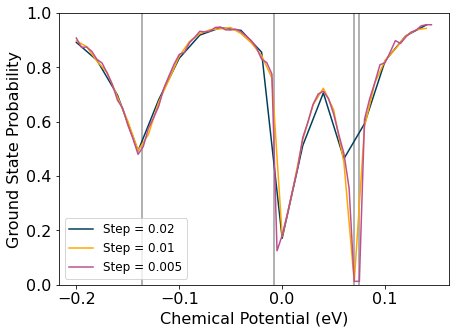

In [154]:
import matplotlib.font_manager as font_manager
plt.rcParams["figure.figsize"] = (7,5)

plt.axvline(x=-0.0683343884736*2.0,color='black',alpha=0.4)
plt.axvline(x=-0.0040305875*2.0,color='black',alpha=0.4)
plt.axvline(x=0.0348562739206*2.0,color='black',alpha=0.4)
plt.axvline(x=0.0375087020*2.0,color = 'black',alpha=0.4)

plt.plot(ch_1*2.0,prob_1_s/2500.0,color=newcmp(0.0),Label = 'Step = 0.02')
plt.plot(ch_2*2.0,prob_2_s/2500.0,color=newcmp(1.0),Label = 'Step = 0.01')
plt.plot(ch_3*2.0,prob_3_s/2500.0,color=newcmp(0.5),Label = 'Step = 0.005')


import matplotlib as mpl
mpl.rc('font',family='Arial')
hfont = {'fontname':'Arial'}
plt.xlabel('Chemical Potential (eV)',fontsize=16,fontname="Arial")
plt.xticks([-0.2,-0.1,0.0,0.1])
plt.ylim([0.0,1.0])
plt.ylabel('Ground State Probability',fontsize=16,fontname="Arial")
plt.xticks(fontsize = 16,fontname = "Arial") 
plt.yticks(fontsize = 16,fontname = "Arial") 
font = font_manager.FontProperties(family='Arial',size=12)
plt.legend(prop=font)

plt.savefig('Deviation_Check_Final_submission.pdf',bbox_inches='tight')
plt.show()

In [155]:
print(min(prob_1_s))
print(min(prob_2_s))
print(min(prob_3_s))

428.0
27.0
32.0


In [171]:
print(prob_2_s/2500)

[0.8972 0.8764 0.8232 0.7808 0.6912 0.6024 0.494  0.5528 0.6724 0.7548
 0.8412 0.8952 0.9244 0.9384 0.9416 0.9464 0.9244 0.89   0.8432 0.7612
 0.178  0.344  0.5344 0.662  0.7232 0.6436 0.4496 0.0108 0.5816 0.7428
 0.8256 0.8676 0.9156 0.938  0.9436]


In [175]:
print(prob_2_s[27])
print(ch_2[27]*2.0)

27.0
0.07


In [176]:
print(27/2500)

0.0108


In [169]:
print(len(lat_2_5))
print(len(lat_5_0))
print(len(lat_7_5))

1
1
1


In [166]:
from ase.io import write
val = lat_2_5[0]
val = np.ones((16))
atoms.numbers = ((val*25)+54)
print(atoms.numbers)
write('atoms_test_1.png', atoms * (3, 3, 1))

[79 79 79 79 79 79 79 79 79 79 79 79 79 79 79 79]
